# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, widgets
import os
from scipy.interpolate import interp1d, griddata
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline

# Config

In [3]:
config = {}

# ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

# path for figures to store
config['outpath_figs'] = "C:/Bachelorarbeit/figures/Geschwindigkeit/FURWET/"
# path for output data
config['outpath_data'] = "C:/Bachelorarbeit/data/waveformsFURWET/"

In [4]:
outpath = config['outpath_figs']
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")
font_title=17
font_ax=13
font_leg=11

# Hilfsfunktionen


In [20]:
# Hilfsfunktion zum Erzeugen eines Polarplots
def plot_polar_subplot(ax, df, title):
    ratio_cols = [col for col in df.columns if col.startswith('ratio_')]
    freqs = [float(col.split('_')[1][:-2]) for col in ratio_cols]
   # freqs=freqs[1:19]
    angles = np.deg2rad(df['backazimuth'].values)

    for freq, col in zip(freqs, ratio_cols):
        r = np.full_like(angles, freq)
        values = df[col].values
        sc = ax.scatter(angles, r, c=values, cmap='viridis', alpha=0.75, s=10)

    ax.set_rlabel_position(170)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(title)
   # Frequenzen sortieren und nur jedes 10. Label auswählen
    all_freqs = sorted(set(freqs))
    label_freqs = all_freqs[5::8]  # jedes 10. Element
    
    # Nur diese anzeigen und beschriften
    ax.set_yticks(label_freqs)
    ax.set_yticklabels([f"{f:.1f} Hz" for f in label_freqs], fontsize=11)
    return sc


In [21]:
def plot_component(ax, df, title):
    ratio_cols = [col for col in df.columns if col.startswith("ratio_")]
    frequencies = [float(col.split("_")[1][:-2]) for col in ratio_cols]

    # Plot nach Tiefenbereichen
    for (dmin, dmax), label in zip(depth_bins, depth_labels):
        df_subset = df[(df["depth"] >= dmin) & (df["depth"] < dmax)]
        num_events = len(df_subset)
        if df_subset.empty:
            continue

        mean_ratios = df_subset[ratio_cols].mean()
        sem_ratios = df_subset[ratio_cols].sem()
        legend_label = f"depth: {label} (n = {num_events})"

        if dmin == 0 and dmax == 700:
            ax.plot(frequencies, mean_ratios.values, linestyle='--', linewidth=2, label=legend_label)
        else:
            ax.plot(frequencies, mean_ratios.values, linestyle='-', label=legend_label)

        ax.fill_between(frequencies,
                        mean_ratios.values - sem_ratios.values,
                        mean_ratios.values + sem_ratios.values,
                        alpha=0.2)

    # Gesamtmittelwert über alle Tiefen (ohne SEM)
    overall_mean = df[ratio_cols].mean()
    ax.plot(frequencies,
            overall_mean.values,
            color='black',
            linestyle=':',
            linewidth=2,
            label='Overall mean (all depths)')

    ax.set_xlabel("Frequency [Hz]",fontsize=font_ax)
    ax.set_ylabel("Mean ratio (FUR/WET)",fontsize=font_ax)
    ax.set_title(title,fontsize=font_title)
    ax.grid(True)
    ax.legend(loc='lower right',fontsize=font_leg)

In [22]:
def add_break_marks(ax_left, ax_right):
    d = .015
    kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
    ax_left.spines['right'].set_visible(False)
    ax_right.spines['left'].set_visible(False)
    ax_left.tick_params(labelright=False)
    ax_right.yaxis.tick_right()
    ax_left.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    ax_left.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    kwargs.update(transform=ax_right.transAxes)
    ax_right.plot((-d, +d), (-d, +d), **kwargs)
    ax_right.plot((-d, +d), (1 - d, 1 + d), **kwargs)

In [23]:
# Funktion zum Erkennen von Ausreißern via IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Funktion zur Vorbereitung der Daten
def prepare_plot_data(df):
    ratio_cols = [col for col in df.columns if col.startswith("ratio_")]
    frequencies = [float(col.split("_")[1][:-2]) for col in ratio_cols]
    return ratio_cols, frequencies

# Hilfsfunktion zum Zeichnen eines Rechtecks
def add_region(ax, lon_min, lon_max, lat_min, lat_max, label, color='red', alpha=0.2):
    rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                     linewidth=1, edgecolor=color, facecolor=color, alpha=alpha,
                     transform=ccrs.PlateCarree(), label=label)
    ax.add_patch(rect)

def smooth_line(x, y, points=500):
    x = np.array(x)
    y = np.array(y)
    x_new = np.linspace(x.min(), x.max(), points)
    spline = make_interp_spline(x, y, k=4)  # kubische Interpolation
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Funktion zur Erstellung der Interpolationsdaten
def prepare_interpolation_data(df):
    ratio_cols = [col for col in df.columns if col.startswith('ratio_')]
    freqs = [float(col.split('_')[1][:-2]) for col in ratio_cols]

    theta_list = []
    r_list = []
    z_list = []

    for freq, col in zip(freqs, ratio_cols):
        theta = np.deg2rad(df['backazimuth'].values)
        r = np.full_like(theta, freq)
        z = df[col].values

        theta_list.extend(theta)
        r_list.extend(r)
        z_list.extend(z)

    theta_array = np.array(theta_list)
    r_array = np.array(r_list)
    z_array = np.array(z_list)

    # Periodizität sicherstellen
    theta_array_extended = np.concatenate([theta_array, theta_array + 2 * np.pi])
    r_array_extended = np.concatenate([r_array, r_array])
    z_array_extended = np.concatenate([z_array, z_array])

    return theta_array_extended, r_array_extended, z_array_extended, min(freqs), max(freqs)

def plot_component_with_sem(ax, df, color, label):
    # Frequenzen extrahieren
    ratio_cols = [col for col in df.columns if col.startswith("ratio_")]
    frequencies = [float(col.split("_")[1][:-2]) for col in ratio_cols]

    # Berechnungen
    mean_ratios = df[ratio_cols].mean()
    sem_ratios = df[ratio_cols].sem()
    std_ratios = df[ratio_cols].std()
    num_events = len(df)

    # Originale Werte als Arrays
    freq_array = np.array(frequencies)
    mean_array = mean_ratios.values
    sem_array = sem_ratios.values
    std_array = std_ratios.values

    # Glätten
    x_smooth, mean_smooth = smooth_line(freq_array, mean_array)
    _, sem_smooth = smooth_line(freq_array, sem_array)
    _, std_smooth = smooth_line(freq_array, std_array)

    # Plot: Glatte Linie
    ax.plot(x_smooth, mean_smooth, color=color, linewidth=2, label=f"{label} (n = {num_events})")
    ax.fill_between(x_smooth,
                    mean_smooth - sem_smooth,
                    mean_smooth + sem_smooth,
                    color=color,
                    alpha=0.3,
                    label=f"{label} ± SEM")


## Verhältnis gegen Frequenz

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")

# Komponenten plotten
plot_component_with_sem(ax, df_T, color='blue', label='Transversal component')
plot_component_with_sem(ax, df_Z, color='green', label='Vertical component')

# Achsen und Titel
ax.set_xlabel("Frequency (Hz)",fontsize=font_ax)
ax.set_ylabel("Mean ratio (FUR/WET)",fontsize=font_ax)
ax.set_title("Mean ratio per frequency (± SEM)",fontsize=font_title)
ax.grid(True)
ax.legend(loc='best', fontsize=font_leg)

# Layout & speichern
plt.tight_layout()
plt.savefig(outpath + "meanratio_freqency_TandZ_SEM_FURWET.png", dpi=300)
plt.close()


# Tiefen


### Verhältnis gegen Frequenz unterteilt in Tiefengruppen

In [98]:
# Konfiguration
depth_bins = [(0, 100), (100, 700)]
depth_labels = ["0–100 km", "100–700 km"]
full_range = (0, 700)
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")

In [99]:
# Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Y-Achsenbereiche setzen
##axs[0].set_ylim(0.8, 3.5)
#axs[1].set_ylim(0.8, 1.6)

# Komponenten plotten
plot_component(axs[0], df_T, "Transversal component")
plot_component(axs[1], df_Z, "Vertical component")
axs[0].text(0.02, 0.95, "a)", transform=axs[0].transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
axs[1].text(0.02, 0.95, "b)", transform=axs[1].transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
# Formatierung & Speichern
plt.suptitle("Mean ratio (FUR/WET) per frequency divided by depth range (± SEM)",fontsize=font_title)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(outpath + "meanratio_freqency_depths_FURWET.png", dpi=300)

plt.close()

## Verhältnis gegen Tiefe


In [42]:
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")
freq_cols = [col for col in df_T.columns if col.startswith("ratio_")]

# Sortieren nach Tiefe
df_T = df_T.sort_values("depth")
df_Z = df_Z.sort_values("depth")

# Über alle Frequenzen mitteln 
T_avg = df_T[freq_cols].mean(axis=1)
Z_avg = df_Z[freq_cols].mean(axis=1)

# Ausreißer erkennen
outliers_T = detect_outliers_iqr(T_avg)
outliers_Z = detect_outliers_iqr(Z_avg)

# Nur "gute" Werte für Glättung verwenden
depth_T = df_T["depth"].values
depth_Z = df_Z["depth"].values

T_good_depth = depth_T[~outliers_T]
T_good_values = T_avg[~outliers_T]

Z_good_depth = depth_Z[~outliers_Z]
Z_good_values = Z_avg[~outliers_Z]

# Glätten auf guten Daten
T_smooth_good = savgol_filter(T_good_values, window_length=70, polyorder=3)
Z_smooth_good = savgol_filter(Z_good_values, window_length=70, polyorder=3)

# Interpolieren der glatten Werte auf alle Tiefen (linear)
interp_T = interp1d(T_good_depth, T_smooth_good, kind='linear', bounds_error=False, fill_value="extrapolate")
interp_Z = interp1d(Z_good_depth, Z_smooth_good, kind='linear', bounds_error=False, fill_value="extrapolate")

T_smooth = interp_T(depth_T)
Z_smooth = interp_Z(depth_Z)

# Tiefenbereiche für Achsenbruch
x1_start, x1_end = 0, 300
x2_start, x2_end = 570, 660

range1 = x1_end - x1_start
range2 = x2_end - x2_start

# Subplots 2x2
fig, ((ax1_T, ax2_T), (ax1_Z, ax2_Z)) = plt.subplots(
    2, 2, sharey='row', figsize=(12, 6),
    gridspec_kw={'width_ratios': [range1, range2], 'wspace': 0.05, 'hspace': 0.2}, 
)

# T-Komponente
ax1_T.scatter(depth_T[~outliers_T], T_avg[~outliers_T], color='blue', alpha=0.5, )
ax1_T.scatter(depth_T[outliers_T], T_avg[outliers_T], color='red', alpha=0.7)
ax1_T.plot(depth_T, T_smooth, color='blue', linewidth=2)
ax1_T.set_xlim(x1_start, x1_end)
ax1_T.set_ylabel("Mean spectralratio",fontsize=font_ax)
ax1_T.set_title("Transversal component",fontsize=font_ax)

ax2_T.scatter(depth_T[~outliers_T], T_avg[~outliers_T], color='blue', alpha=0.5,label="Inliers")
ax2_T.scatter(depth_T[outliers_T], T_avg[outliers_T], color='red', alpha=0.7, label="Outliers")
ax2_T.plot(depth_T, T_smooth, color='blue', linewidth=2, label="Smoothed mean")
ax2_T.set_xlim(x2_start, x2_end)

# Z-Komponente
ax1_Z.scatter(depth_Z[~outliers_Z], Z_avg[~outliers_Z], color='green', alpha=0.5)
ax1_Z.scatter(depth_Z[outliers_Z], Z_avg[outliers_Z], color='red', alpha=0.7)
ax1_Z.plot(depth_Z, Z_smooth, color='green', linewidth=2 )
ax1_Z.set_xlim(x1_start, x1_end)
ax1_Z.set_ylabel("Mean spectralratio",fontsize=font_ax)
ax1_Z.set_xlabel("Depth (km)",fontsize=font_ax)
ax1_Z.set_title("Vertical component",fontsize=font_ax)
ax2_Z.scatter(depth_Z[~outliers_Z], Z_avg[~outliers_Z], color='green', alpha=0.5, label="Inliers")
ax2_Z.scatter(depth_Z[outliers_Z], Z_avg[outliers_Z], color='red', alpha=0.7,label="Outliers")
ax2_Z.plot(depth_Z, Z_smooth, color='green',label="Smoothed mean", linewidth=2)
ax2_Z.set_xlim(x2_start, x2_end)
#ax2_Z.set_xlabel("Depth (km)",fontsize=font_ax)
ax1_T.set_ylim(0,13)
ax1_Z.set_ylim(0,13)
add_break_marks(ax1_T, ax2_T)
add_break_marks(ax1_Z, ax2_Z)
ax1_Z.text(0.02, 0.95, "b)", transform=ax1_Z.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
ax1_T.text(0.02, 0.95, "a)", transform=ax1_T.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
fig.suptitle("Spectralratio (FUR/WET) vs. event depths (Mean of all frequencies)",fontsize=font_title) 
# Legenden
ax2_T.legend(loc="upper right",fontsize=font_leg)
ax2_Z.legend(loc="upper right",fontsize=font_leg)
plt.savefig(config['outpath_figs'] + "meanratio_vs_depth_FURWET.png", dpi=300)
plt.close()


### Verhältnis gg DIstance

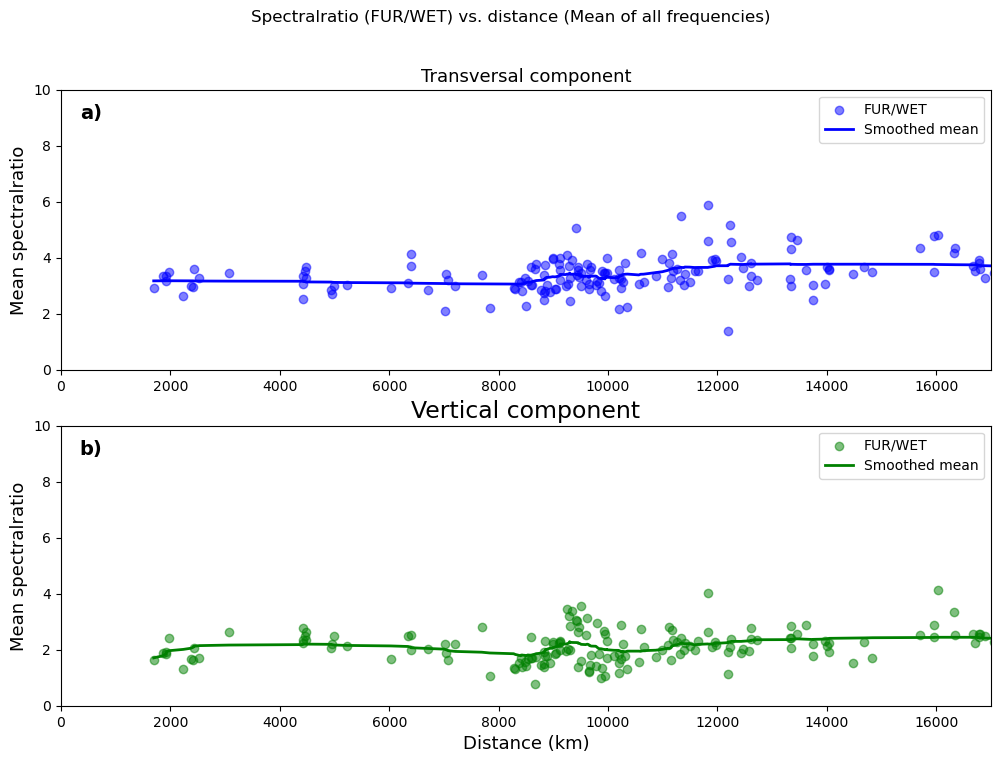

In [101]:
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")
# Alle Frequenzspalten finden (z.B. ratio_...)
freq_cols = [col for col in df_T.columns if col.startswith("ratio_")]
freq_cols = freq_cols[1:19]
# Sortieren nach Tiefe
df_T = df_T.sort_values("distance")
df_Z = df_Z.sort_values("distance")

# Mittelwert über alle Frequenzen
T_avg = df_T[freq_cols].mean(axis=1)
Z_avg = df_Z[freq_cols].mean(axis=1)

# Alle Daten für Glättung verwenden
depth_T = df_T["distance"].values
depth_Z = df_Z["distance"].values

T_smooth = savgol_filter(T_avg, window_length=70, polyorder=3)
Z_smooth = savgol_filter(Z_avg, window_length=70, polyorder=3)

# Tiefenbereiche für Achsenbruch
x1_start, x1_end = 0, 17000

range1 = x1_end - x1_start


# Subplots 2x2
fig, (ax1_T,ax1_Z) = plt.subplots(
    2, 1,  figsize=(12, 6),
     
)

# T-Komponente
ax1_T.scatter(depth_T, T_avg, color='blue', alpha=0.5, label='FUR/WET')
ax1_T.plot(depth_T, T_smooth, color='blue', linewidth=2,label='Smoothed mean')
ax1_T.set_xlim(x1_start, x1_end)
ax1_T.set_ylabel("Mean spectralratio",fontsize=font_ax)
ax1_T.set_title("Transversal component",fontsize=font_ax)


# Z-Komponente
ax1_Z.scatter(depth_Z, Z_avg, color='green', alpha=0.5, label='FUR/WET')
ax1_Z.plot(depth_Z, Z_smooth, color='green', linewidth=2, label='Smoothed mean')
ax1_Z.set_xlim(x1_start, x1_end)
ax1_Z.set_ylabel("Mean spectralratio",fontsize=font_ax)
ax1_Z.set_xlabel("Distance (km)",fontsize=font_ax)
ax1_Z.set_title("Vertical component",fontsize=font_title)
ax1_T.set_ylim(0,10)
ax1_Z.set_ylim(0,10)


# Achsenbeschriftungen
ax1_Z.text(0.02, 0.95, "b)", transform=ax1_Z.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')
ax1_T.text(0.02, 0.95, "a)", transform=ax1_T.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

# Titel und Legenden
fig.suptitle("Spectralratio (FUR/WET) vs. distance (Mean of all frequencies)")
ax1_T.legend(loc="upper right")
ax1_Z.legend(loc="upper right")

# Speichern
plt.savefig(config['outpath_figs'] + "meanratio_vs_dist_1Hz_FURWET.png", dpi=300)
plt.close()


## Weltkarte

In [9]:
# Regionen definieren
region_bins = [1, 2, 4, 6, 7]
region_labels = ["Europe", "Asia and Philippines", "North and South America", "Ozeania", "Elsewhere"]
# CSV-Dateien laden

In [10]:
df = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
# Daten aus den Spalten extrahieren
lats = df['lat'].values
lons = df['lon'].values
magnitudes = df['magnitude'].values
num=len(df)
mapplot = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Station-Koordinaten
sta_lat = config['ROMY_lat']
sta_lon = config['ROMY_lon']
ax.scatter(sta_lon, sta_lat, color='blue', s=100, marker='*', edgecolor='k', transform=ccrs.PlateCarree(), label='FUR')

ax.legend(loc='upper right')

sc = ax.scatter(lons, lats, c=magnitudes, cmap='viridis', s=[m**3 for m in magnitudes], alpha=0.7, edgecolor='k', transform=ccrs.PlateCarree())

ax.set_title(f"Earthquake distribution ({num} events)",fontsize=font_title)
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("Magnitude", fontsize=font_ax)

# Regionen markieren
add_region(ax, -50, 50, 30, 60, "Region 1 (Europe)", color="red")
add_region(ax, 60, 180, 15, 60, "Region 2 (Asia)", color="blue")
add_region(ax, 100, 180, -10, 15, "Region 2 (Asia)", color="blue")
add_region(ax, -170, -60, 5, 60, "Region 3 (Northamerica)", color="green")
add_region(ax, -120, -50, -80, 5, "Region 3 (Southamerica)", color="green")
add_region(ax, 90, 180, -60, -10, "Region 4 (Ozeania)", color="orange")
add_region(ax, -180, -150, -60, -10, "Region 4 (Ozeania)", color="orange")

# Duplikate in Legende vermeiden
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left',fontsize=font_leg)

mapplot_path = config['outpath_figs'] + "worldmap_earthquke_distribution_FURWET.png"
mapplot.savefig(mapplot_path, dpi=150, bbox_inches='tight')
print(f" -> Kartenplot gespeichert unter: {mapplot_path}")
plt.close()

 -> Kartenplot gespeichert unter: C:/Bachelorarbeit/figures/Geschwindigkeit/FURWET/worldmap_earthquke_distribution_FURWET.png


In [104]:
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")
# Plotdaten extrahieren
ratio_cols_T, frequencies_T = prepare_plot_data(df_T)
ratio_cols_Z, frequencies_Z = prepare_plot_data(df_Z)

# Gesamtdurchschnitt (alle Regionen)
mean_ratios_all_T = df_T[ratio_cols_T].mean()
sem_ratios_all_T = df_T[ratio_cols_T].sem()
mean_ratios_all_Z = df_Z[ratio_cols_Z].mean()
sem_ratios_all_Z = df_Z[ratio_cols_Z].sem()
n_all_T = len(df_T)
n_all_Z = len(df_Z)

# Gültige Regionen sammeln (mind. 30 Events in T **oder** Z)
valid_regions = []
for reg, label in zip(region_bins, region_labels):
    n_T = len(df_T[df_T["region"] == reg])
    n_Z = len(df_Z[df_Z["region"] == reg])
    if n_T >= 30 or n_Z >= 30:
        valid_regions.append((reg, label, n_T, n_Z))

# Subplots vorbereiten
num_plots = len(valid_regions)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 4 * num_plots), sharex=True)
if num_plots == 1:
    axes = [axes]

panel_labels = list(string.ascii_lowercase)

for idx, (reg, label, n_T, n_Z) in enumerate(valid_regions):
    ax = axes[idx]

    # --- Transversal-Komponente ---
    if n_T >= 30:
        df_region_T = df_T[df_T["region"] == reg]
        mean_T = df_region_T[ratio_cols_T].mean()
        sem_T = df_region_T[ratio_cols_T].sem()

        ax.plot(frequencies_T, mean_T.values, label=f"T (n={n_T})", color='tab:blue')
        ax.fill_between(frequencies_T,
                        mean_T.values - sem_T.values,
                        mean_T.values + sem_T.values,
                        alpha=0.2, color='tab:blue')

        # Globaler Mittelwert T
        ax.plot(frequencies_T, mean_ratios_all_T.values, linestyle='--', color='navy', label=f"T global (n={n_all_T})")
        ax.fill_between(frequencies_T,
                        mean_ratios_all_T.values - sem_ratios_all_T.values,
                        mean_ratios_all_T.values + sem_ratios_all_T.values,
                        alpha=0.15, color='navy')

    # --- Vertikal-Komponente ---
    if n_Z >= 30:
        df_region_Z = df_Z[df_Z["region"] == reg]
        mean_Z = df_region_Z[ratio_cols_Z].mean()
        sem_Z = df_region_Z[ratio_cols_Z].sem()

        ax.plot(frequencies_Z, mean_Z.values, label=f"Z (n={n_Z})", color='tab:orange')
        ax.fill_between(frequencies_Z,
                        mean_Z.values - sem_Z.values,
                        mean_Z.values + sem_Z.values,
                        alpha=0.2, color='tab:orange')

        # Globaler Mittelwert Z
        ax.plot(frequencies_Z, mean_ratios_all_Z.values, linestyle='--', color='darkorange', label=f"Z global (n={n_all_Z})")
        ax.fill_between(frequencies_Z,
                        mean_ratios_all_Z.values - sem_ratios_all_Z.values,
                        mean_ratios_all_Z.values + sem_ratios_all_Z.values,
                        alpha=0.15, color='darkorange')

    ax.grid(True)
    ax.set_ylabel("Mean spectral ratio (FUR/WET)",fontsize=font_ax)
    if idx == num_plots - 1:
        ax.set_xlabel("Frequency [Hz]",fontsize=font_ax)

    ax.legend(fontsize=9)
    ax.set_title(f"{panel_labels[idx]}) {label}", loc='left', fontsize=12, fontweight='bold')

# Gesamt-Titel und Layout
fig.suptitle("Mean ratio per frequency for each region (+/- SEM)", fontsize=font_title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(config['outpath_figs'] + "meanratio_frequency_regions_FURWET_combined.png", dpi=300)
plt.close()


# Polarplot

## Polarplot Erdbebenverteilung

In [105]:
df = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
# Werte aus der CSV-Datei extrahieren
theta = np.deg2rad(df['backazimuth'])  # Winkel in Radian
r = df['distance'].values              # Abstand in km
magnitudes = df['magnitude'].values    # Magnitude
num_events = len(df)
# Polarplot erstellen
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, polar=True)

sc = ax.scatter(theta, r, c=magnitudes, cmap='viridis', s=[m**3 for m in magnitudes], alpha=0.7)

ax.set_theta_zero_location('N')   # Norden oben
ax.set_theta_direction(-1)        # Uhrzeigersinn
ax.set_title(f"Earthquake distribution relative to FUR ({num_events} events)", va='bottom',fontsize=font_title)
ax.set_rlabel_position(135)
#ax.text(np.deg2rad(132), max(r)*1.37, f"{num_events} events", fontsize=12, 
      #  ha='left', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
# Farbleiste hinzufügen
cbar = plt.colorbar(sc, ax=ax, pad=0.1, shrink = 0.7)
cbar.set_label("Magnitude",fontsize=font_ax)

# Speichern
polarplot_path = config['outpath_figs'] + "polarplot_earthquake_distribution_FURWET.png"
plt.savefig(polarplot_path, dpi=300, bbox_inches='tight')
print(f" -> Polarplot gespeichert unter: {polarplot_path}")
plt.close()


 -> Polarplot gespeichert unter: C:/Bachelorarbeit/figures/Geschwindigkeit/FURWET/polarplot_earthquake_distribution_FURWET.png


## Polarplot mit Verhältnis/Frequenz/Backazimuth

In [34]:
df_T = pd.read_csv(outpath + "spektralanalyse_ergebnisse_T.csv")
df_Z = pd.read_csv(outpath + "spektralanalyse_ergebnisse_Z.csv")
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(14, 7))

sc1 = plot_polar_subplot(ax1, df_T, 'Transversal component')
sc2 = plot_polar_subplot(ax2, df_Z, 'Vertical component')

# Gemeinsame Farbskala
cbar = fig.colorbar(sc2, ax=[ax1, ax2], pad=0.1, shrink=0.7, extend='both')
cbar.set_label('Spectral ratio (FUR/WET)',fontsize=font_ax)
sc2.set_clim(1, 20)
plt.suptitle("Polar plot of spectral ratios as a function of frequency and Backazimuth",fontsize=font_title, y=0.9)
#plt.tight_layout()
plt.savefig(config['outpath_figs'] + "polarplot_backazimuth_frequence_combined_FURWET.png", dpi=300,bbox_inches='tight')
plt.close()


## Interpolierter Polarplot mit Verhältnis/Frequenz/Backazimuth

In [40]:
# Interpolationsdaten vorbereiten
theta_z, r_z, z_z, rmin, rmax = prepare_interpolation_data(df_Z)
theta_t, r_t, z_t, _, _ = prepare_interpolation_data(df_T)

# Gitter erzeugen
theta_lin = np.linspace(0, 2 * np.pi, 8, endpoint=False)
r_lin = np.linspace(rmin, rmax, 50)
theta_grid, r_grid = np.meshgrid(theta_lin, r_lin)

# Interpolation
z_grid_z = griddata((theta_z, r_z), z_z, (theta_grid, r_grid), method='nearest')
z_grid_t = griddata((theta_t, r_t), z_t, (theta_grid, r_grid), method='nearest')

# Plots nebeneinander
fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(14, 7))

# Plot Z-Komponente
pcm1 = axs[1].pcolormesh(theta_grid, r_grid, z_grid_z, cmap='viridis', shading='auto')
pcm1.set_clim(1, 20)
axs[1].set_title('Vertical component')
axs[1].set_rlabel_position(110)
axs[1].set_theta_zero_location('N')
axs[1].set_theta_direction(-1)
#axs[0].set_rlim(0.01,1)
#axs[1].set_rlim(0.01,1)
# Plot T-Komponente
pcm2 = axs[0].pcolormesh(theta_grid, r_grid, z_grid_t, cmap='viridis', shading='auto')
pcm2.set_clim(1, 20)
axs[0].set_title('Transversal component')
axs[0].set_rlabel_position(110)
axs[0].set_theta_zero_location('N')
axs[0].set_theta_direction(-1)
all_freqs = [0.1,0.5,1,1.5,2]
label_freqs = all_freqs#[5::8]  # jedes 10. Element
'''
# Nur diese anzeigen und beschriften
axs[0].set_yticks(label_freqs)
axs[0].set_yticklabels([f"{f:.1f} Hz" for f in label_freqs], fontsize=font_leg,color='red')
axs[1].set_yticks(label_freqs)
axs[1].set_yticklabels([f"{f:.1f} Hz" for f in label_freqs], fontsize=font_leg,color='lightgray') 
'''
import matplotlib.patheffects as path_effects

# Setzt die yticks wie gehabt
axs[0].set_yticks(label_freqs)
axs[1].set_yticks(label_freqs)

# Erstelle die Y-Labels mit weißer Schrift
yticklabels_ax0 = axs[0].set_yticklabels(
    [f"{f:.1f} Hz" for f in label_freqs],
    fontsize=font_leg,
    color='white'  # weiße Schrift
)
yticklabels_ax1 = axs[1].set_yticklabels(
    [f"{f:.1f} Hz" for f in label_freqs],
    fontsize=font_leg,
    color='white'  # weiße Schrift
)

# Füge schwarzen Rand hinzu
for label in yticklabels_ax0:
    label.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

for label in yticklabels_ax1:
    label.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

# Gemeinsame Farbskala
cbar = fig.colorbar(pcm2, ax=axs, orientation='vertical', pad=0.1, shrink=0.7, extend='both')
cbar.set_label('Spectral ratio (FUR/WET)',fontsize=font_ax)

#plt.tight_layout()
plt.suptitle("Polar plot of spectral ratios as a function of frequency and Backazimuth (Interpolated)",fontsize=font_title, y=0.9)
plt.savefig(config['outpath_figs'] + "interpolierter_polarplot_zt_FURWET.png", dpi=300,bbox_inches='tight')
plt.close()


## Angular dependencies

In [108]:
# Frequenzbänder inkl. "alle Frequenzen"
bands = {
    'Low (0.01–0.5 Hz)': (0.01, 0.5),
    'Mid (0.5–1 Hz)': (0.5, 1),
    'High (1-2 Hz)': (1, 2),
    'All Frequencies': (0.01, 2)
}
band_labels = list(bands.keys())

# Farben (für 4 Subplots)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

In [109]:
# CSV einlesen
df = pd.read_csv(outpath + "spektralanalyse_ergebnisse_z.csv")

# Frequenzspalten extrahieren
ratio_cols = [col for col in df.columns if col.startswith('ratio_')]
freqs = np.array([float(col.split('_')[1][:-2]) for col in ratio_cols])
ratios = df[ratio_cols].values
backazimuths = df['backazimuth'].values

# Subplots vorbereiten (2×2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10), sharex=True)
axes = axes.flatten()  # 2D → 1D-Liste
panel_labels = ['a)', 'b)', 'c)', 'd)']
i=0
for ax, label, color in zip(axes, band_labels, colors):
    fmin, fmax = bands[label]
    band_indices = np.where((freqs >= fmin) & (freqs < fmax))[0]
    if len(band_indices) == 0:
        continue

    band_ratios = ratios[:, band_indices]
    mean_ratios = np.mean(band_ratios, axis=1)
    std_ratios = np.std(band_ratios, axis=1)

    # Ausreißer mit IQR entfernen
    Q1 = np.percentile(mean_ratios, 25)
    Q3 = np.percentile(mean_ratios, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    is_outlier = (mean_ratios < lower_bound) | (mean_ratios > upper_bound)
    is_inlier = ~is_outlier

    # Sortieren nach Backazimuth
    sorted_idx = np.argsort(backazimuths)
    sorted_baz = backazimuths[sorted_idx]
    sorted_mean = mean_ratios[sorted_idx]
    sorted_std = std_ratios[sorted_idx]
    sorted_is_inlier = is_inlier[sorted_idx]
    sorted_is_outlier = is_outlier[sorted_idx]

    # Scatterplot Inlier & Outlier
    ax.scatter(sorted_baz[sorted_is_inlier], sorted_mean[sorted_is_inlier],
               color=color, alpha=0.6, s=12, label='Inlier')
    ax.scatter(sorted_baz[sorted_is_outlier], sorted_mean[sorted_is_outlier],
               color='red', marker='x', s=30, label='Outlier')

    # Glättung und Varianz nur mit Inliern
    baz_clean = sorted_baz[sorted_is_inlier]
    mean_clean = sorted_mean[sorted_is_inlier]
    std_clean = sorted_std[sorted_is_inlier]

    if len(baz_clean) > 5:
        baz_interp = np.linspace(baz_clean.min(), baz_clean.max(), 500)
        interp_mean = interp1d(baz_clean, mean_clean, kind='linear')(baz_interp)
        interp_std = interp1d(baz_clean, std_clean, kind='linear')(baz_interp)

        window = min(95, len(baz_interp) // 2 * 2 + 1)
        mean_smooth = savgol_filter(interp_mean, window_length=window, polyorder=3)
        std_smooth = savgol_filter(interp_std, window_length=window, polyorder=3)

        # Mittelwert-Linie
        ax.plot(baz_interp, mean_smooth, color=color, linewidth=2, label='smoothed mean')

        # Varianz-Schatten ±1 Std-Abweichung
        ax.fill_between(baz_interp, mean_smooth - std_smooth, mean_smooth + std_smooth,
                        color=color, alpha=0.3, label='± Standard deviation')

    # Achsen und Styling
    ax.set_title(label)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 17)
    ax.grid(True)
    ax.set_xlabel('Backazimuth (°)',fontsize=font_ax)
    ax.set_ylabel('Spepectralratio',fontsize=font_ax)
    ax.legend(loc='upper right',fontsize=font_leg)
    ax.text(0.02, 0.95, panel_labels[i], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')
    i+=1
fig.suptitle('Backazimuth vs. spectralratio (FUR/WET) per frequenceband (Vertical component)', fontsize=font_title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Speichern
plt.savefig(config['outpath_figs'] + "backazimuth_vs_ratio_standarddeviation_z_FURWET.png", dpi=300)
plt.close()


In [110]:
# CSV einlesen
df = pd.read_csv(outpath + "spektralanalyse_ergebnisse_t.csv")

# Frequenzspalten extrahieren
ratio_cols = [col for col in df.columns if col.startswith('ratio_')]
freqs = np.array([float(col.split('_')[1][:-2]) for col in ratio_cols])
ratios = df[ratio_cols].values
backazimuths = df['backazimuth'].values

# Subplots vorbereiten (2×2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10), sharex=True)
axes = axes.flatten()  # 2D → 1D-Liste
panel_labels = ['a)', 'b)', 'c)', 'd)']
i=0
for ax, label, color in zip(axes, band_labels, colors):
    fmin, fmax = bands[label]
    band_indices = np.where((freqs >= fmin) & (freqs < fmax))[0]
    if len(band_indices) == 0:
        continue

    band_ratios = ratios[:, band_indices]
    mean_ratios = np.mean(band_ratios, axis=1)
    std_ratios = np.std(band_ratios, axis=1)

    # Ausreißer mit IQR entfernen
    Q1 = np.percentile(mean_ratios, 25)
    Q3 = np.percentile(mean_ratios, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    is_outlier = (mean_ratios < lower_bound) | (mean_ratios > upper_bound)
    is_inlier = ~is_outlier

    # Sortieren nach Backazimuth
    sorted_idx = np.argsort(backazimuths)
    sorted_baz = backazimuths[sorted_idx]
    sorted_mean = mean_ratios[sorted_idx]
    sorted_std = std_ratios[sorted_idx]
    sorted_is_inlier = is_inlier[sorted_idx]
    sorted_is_outlier = is_outlier[sorted_idx]

    # Scatterplot Inlier & Outlier
    ax.scatter(sorted_baz[sorted_is_inlier], sorted_mean[sorted_is_inlier],
               color=color, alpha=0.6, s=12, label='Inlier')
    ax.scatter(sorted_baz[sorted_is_outlier], sorted_mean[sorted_is_outlier],
               color='red', marker='x', s=30, label='Outlier')

    # Glättung und Varianz nur mit Inliern
    baz_clean = sorted_baz[sorted_is_inlier]
    mean_clean = sorted_mean[sorted_is_inlier]
    std_clean = sorted_std[sorted_is_inlier]

    if len(baz_clean) > 5:
        baz_interp = np.linspace(baz_clean.min(), baz_clean.max(), 500)
        interp_mean = interp1d(baz_clean, mean_clean, kind='linear')(baz_interp)
        interp_std = interp1d(baz_clean, std_clean, kind='linear')(baz_interp)

        window = min(95, len(baz_interp) // 2 * 2 + 1)
        mean_smooth = savgol_filter(interp_mean, window_length=window, polyorder=4)
        std_smooth = savgol_filter(interp_std, window_length=window, polyorder=4)

        # Mittelwert-Linie
        ax.plot(baz_interp, mean_smooth, color=color, linewidth=2, label='smoothed mean')

        # Varianz-Schatten ±1 Std-Abweichung
        ax.fill_between(baz_interp, mean_smooth - std_smooth, mean_smooth + std_smooth,
                        color=color, alpha=0.3, label='± Standard deviation')

    # Achsen und Styling
    ax.set_title(label)
    ax.set_xlim(0, 360)
    ax.set_ylim(0,23)
    ax.grid(True)
    ax.set_xlabel('Backazimuth (°)',fontsize=font_ax)
    ax.set_ylabel('Spectralratio',fontsize=font_ax)
    ax.legend(loc='upper right',fontsize=font_leg)
    ax.text(0.02, 0.95, panel_labels[i], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')
    i+=1
fig.suptitle('Backazimuth vs. spectralratio (FUR/WET) per frequenceband (Transversal component)', fontsize=font_title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Speichern
plt.savefig(config['outpath_figs'] + "backazimuth_vs_ratio_standarddeviation_t_FURWET.png", dpi=300)
plt.close()
